In [1]:
%reset -f

# 0. Import dependencies and load data

In [2]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold

from xgboost import XGBRegressor
from prophet import Prophet

sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "src"))

Importing plotly failed. Interactive plots will not work.


In [3]:
from src.model_utility_functions import (
    preprocess_data,
    split_data,
    evaluate_model,
    cross_validation_scores,
    prepare_prophet_data
)

from src.lag_utility_functions import (
    plot_acf_pacf,
    evaluate_ar_model,
    compare_lag_sets,
    plot_predictions,
    extract_lags
)

from src.ma_utility_functions import (
    evaluate_moving_average,
    compare_moving_average_windows,
    plot_moving_average_predictions,
    extract_ma
)

In [4]:
DATA_FOLDER_PATH = os.path.join(os.path.dirname(os.getcwd()), "data")
BASE_FILE_NAME = "_in_USD_historical_data.csv"

In [5]:
btc = pd.read_csv(os.path.join(DATA_FOLDER_PATH, f"BTC{BASE_FILE_NAME}"))
btc = preprocess_data(btc)
eth = pd.read_csv(os.path.join(DATA_FOLDER_PATH, f"ETH{BASE_FILE_NAME}"))
eth = preprocess_data(eth)
ltc = pd.read_csv(os.path.join(DATA_FOLDER_PATH, f"LTC{BASE_FILE_NAME}"))
ltc = preprocess_data(ltc)

In [6]:
train, test = split_data(btc, train_ratio=0.8)

# 1.1. Find best lags

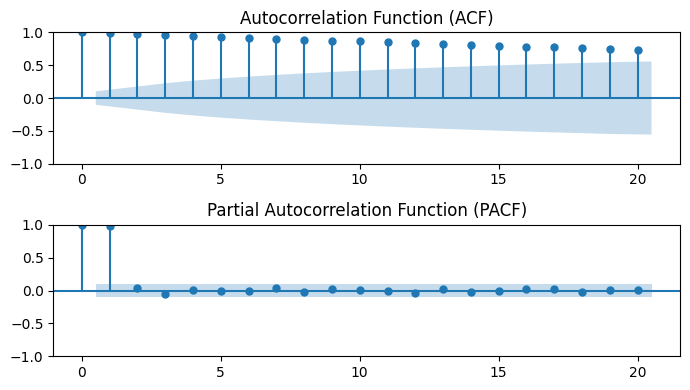

In [7]:
plot_acf_pacf(btc, lags=20)

based on the ACF and PACF results I choose the lags 1, 2, 7, 10

In [8]:
lag_set = (1, 2, 7, 10)

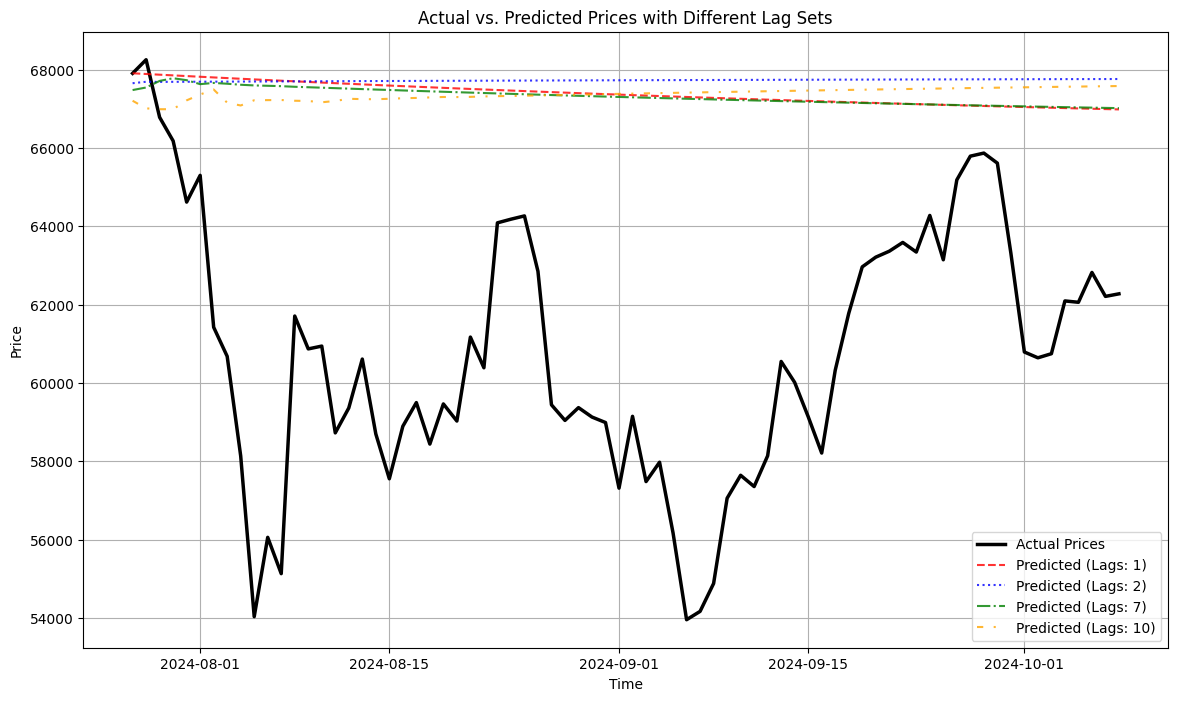

In [9]:
predictions_dict = {}
for lags in lag_set:
    _, predictions = evaluate_ar_model(train, test, lags)
    predictions_dict[lags] = predictions

# Step 5: Plot the actual and predicted values using the predictions_dict
plot_predictions(test, predictions_dict)

In [10]:
compare_lag_sets(btc, lag_set)

Lags: 1, Test MSE: 54894799.2430
Lags: 2, Test MSE: 59404086.3996
Lags: 7, Test MSE: 54021944.8167
Lags: 10, Test MSE: 54609638.1856


{1: np.float64(54894799.24301511),
 2: np.float64(59404086.39963948),
 7: np.float64(54021944.81672851),
 10: np.float64(54609638.18563602)}

based on the lag graph and the different MSE I will choose the lags 1, 7 and 10

# 1.2. Choose  Moving Average windows

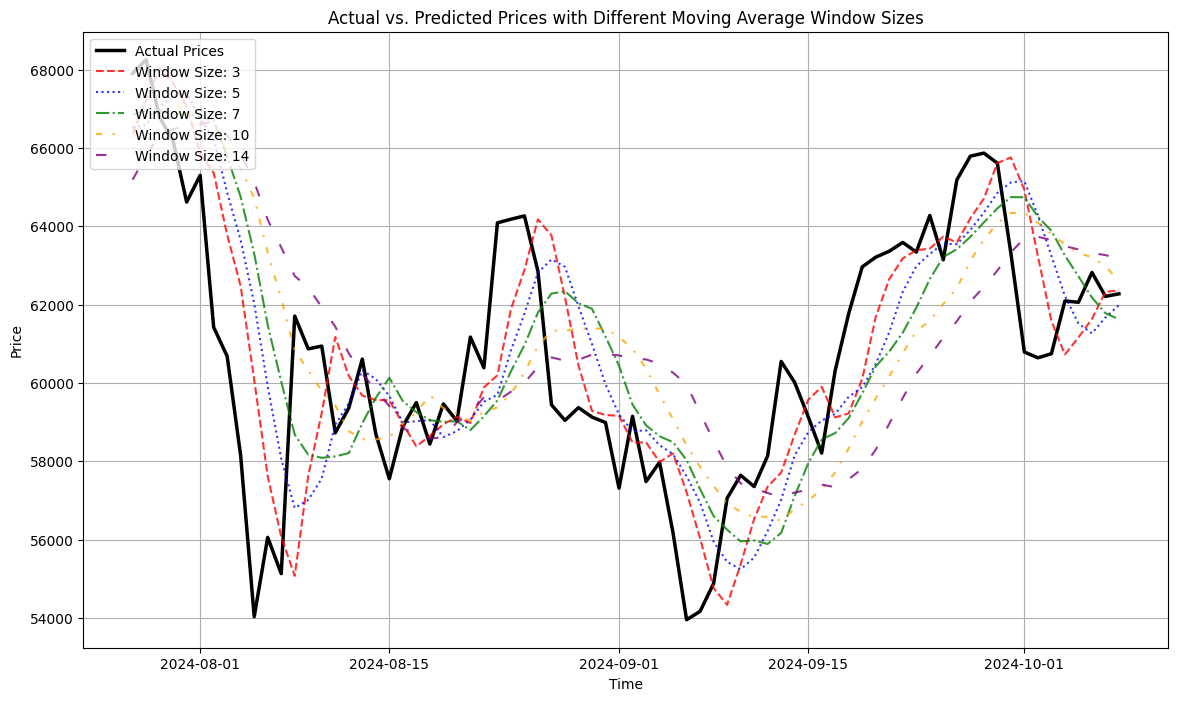

Mean Squared Error for each window size:
Window Size 3: MSE = 4576861.8917
Window Size 5: MSE = 6252397.1875
Window Size 7: MSE = 7631886.2950
Window Size 10: MSE = 9338808.0653
Window Size 14: MSE = 11630820.7254


In [11]:
# artitrary chosen 5 window sizes
window_sizes = [3, 5, 7, 10, 14]


mse_results, predictions_dict = compare_moving_average_windows(btc, window_sizes)


plot_moving_average_predictions(test, predictions_dict)


print("Mean Squared Error for each window size:")
for window_size, mse in mse_results.items():
    print(f"Window Size {window_size}: MSE = {mse:.4f}")


based on the graph and the MSe I will choose 3, 5 and 7 window sizes

# 2. Extract features

In [12]:
# transform all three series into DataFrames
btc = pd.DataFrame(btc)
eth = pd.DataFrame(eth)
ltc = pd.DataFrame(ltc)

In [13]:
chosen_lags = [1, 7, 10]
chosen_windows = [3, 5, 7]

btc = extract_lags(btc, chosen_lags)
eth = extract_lags(eth, chosen_lags)
ltc = extract_lags(ltc, chosen_lags)

btc = extract_ma(btc, chosen_windows)
eth = extract_ma(eth, chosen_windows)
ltc = extract_ma(ltc, chosen_windows)

# 3. Prepare the train and test data

In [14]:
btc['currency_id'] = 0 
eth['currency_id'] = 1  
ltc['currency_id'] = 2

combined_data = pd.concat([btc, eth, ltc])

In [15]:
combined_data["y"] = combined_data["price"].shift(-1)
combined_data = combined_data.dropna()

In [16]:
X = combined_data.drop(columns=['price', 'y'])
y = combined_data['y']

train_size = int(len(combined_data) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 4. Model Comparison

In [17]:
# Hyperparameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Hyperparameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3]
}

In [18]:
rf = RandomForestRegressor(random_state=42)
rf_random = RandomizedSearchCV(estimator=rf,
                                   param_distributions=rf_param_grid,
                                   n_iter=50,
                                   cv=5,
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1)
rf_random.fit(X_train, y_train)
print(f"Best Random Forest Params: {rf_random.best_params_}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.9s[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.8s

[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.9

In [19]:
xgb = XGBRegressor(random_state=42)
xgb_random = RandomizedSearchCV(estimator=xgb,
                                    param_distributions=xgb_param_grid,
                                    n_iter=50,
                                    cv=5,
                                    verbose=2,
                                    random_state=42,
                                    n_jobs=-1)
xgb_random.fit(X_train, y_train)
print(f"Best XGBoost Params: {xgb_random.best_params_}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.9s[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.9s

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max

In [21]:
combined_data

,price,kur_1,kur_7,kur_10,ma_3,ma_5,ma_7,currency_id,y
date,,,,,,,,,
2023-10-25,34503.40,33923.52,28328.07,27177.41,33837.000000,32287.304,31407.810000,0,34157.06
2023-10-26,34157.06,34503.40,28733.78,28518.37,34194.660000,33133.900,32182.564286,0,33907.70
2023-10-27,33907.70,34157.06,29684.37,28409.46,34189.386667,33915.152,32785.897143,0,34090.05
2023-10-28,34090.05,33907.70,29924.08,28328.07,34051.603333,34116.346,33381.035714,0,34535.38
2023-10-29,34535.38,34090.05,30001.44,28733.78,34177.710000,34238.718,34028.741429,0,34494.56
...,...,...,...,...,...,...,...,...,...
2024-10-03,63.49,62.96,68.58,66.96,63.290000,65.200,66.737143,2,64.97
2024-10-04,64.97,63.49,71.16,66.71,63.806667,64.334,65.852857,2,66.31
2024-10-05,66.31,64.97,70.00,66.80,64.923333,64.230,65.325714,2,67.05


In [22]:
from src.model_utility_functions import prepare_prophet_data

In [24]:
prophet_df = combined_data[['price']].rename(columns={'price': 'y'})
prophet_df['ds'] = combined_data.index[:len(prophet_df)]  # Using index as date
prophet_df = prophet_df[['ds', 'y']]

In [25]:
# prophet_df = prepare_prophet_data(combined_data)
model = Prophet()
model.fit(prophet_df)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)
prophet_predictions = forecast['yhat'][-len(y_test):].values


00:36:51 - cmdstanpy - INFO - Chain [1] start processing
00:36:51 - cmdstanpy - INFO - Chain [1] done processing


In [27]:
# evaluate RandomForest model
rf_predictions = rf_random.best_estimator_.predict(X_test)
evaluate_model(y_test.values, rf_predictions, "Random Forest")
cross_validation_scores(rf_random.best_estimator_, X_train, y_train)

2024-10-30 00:37:23,189 - src.model_utility_functions - INFO - Random Forest - Mean Absolute Error (MAE): 4.869730096827893
2024-10-30 00:37:23,190 - src.model_utility_functions - INFO - Random Forest - Mean Squared Error (MSE): 35.54616487336218
2024-10-30 00:37:25,475 - src.model_utility_functions - INFO - Cross-validation MAE: 735.2379 ± 255.2113


array([ -625.38077847,  -446.97751603,  -726.74151123,  -532.00419018,
        -769.76648547, -1417.92308481,  -630.63308428,  -733.34886279,
        -599.53905375,  -870.06443672])

In [32]:
# evaluate XGBoost model
xgb_predictions = xgb_random.best_estimator_.predict(X_test)
evaluate_model(y_test.values, xgb_predictions, "XGBoost")
cross_validation_scores(xgb_random.best_estimator_, X_train, y_train)

2024-10-30 00:39:15,653 - src.model_utility_functions - INFO - XGBoost - Mean Absolute Error (MAE): 105.06330431437493
2024-10-30 00:39:15,654 - src.model_utility_functions - INFO - XGBoost - Mean Squared Error (MSE): 69989.28445461828


2024-10-30 00:39:19,658 - src.model_utility_functions - INFO - Cross-validation MAE: 921.8418 ± 285.6352


array([ -747.85401617,  -570.04284483,  -941.42956631,  -721.02491336,
       -1348.43852974, -1394.37751287,  -846.27523388, -1203.28105551,
        -562.00815814,  -883.68642374])

In [29]:
# evaluate Prophet model
evaluate_model(y_test.values, prophet_predictions, 'Prophet')

2024-10-30 00:37:49,498 - src.model_utility_functions - INFO - Prophet - Mean Absolute Error (MAE): 22415.942245258062
2024-10-30 00:37:49,500 - src.model_utility_functions - INFO - Prophet - Mean Squared Error (MSE): 504514265.1539309


(np.float64(22415.942245258062), np.float64(504514265.1539309))

It seems that the Random Forest is the best performing model